In [62]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import random


In [63]:
ruta_Test= r"C:\Users\erick\Pictures\corn\Test"
ruta_Train= r"C:\Users\erick\Pictures\corn\Train"
ruta_Val= r"C:\Users\erick\Pictures\corn\Val"

#asignamos un numero a cada sub carpeta(clases)
clases = {
    "Cercospora Leaf Spot": 0,
    "Common Rust_": 1,
    "Healthy": 2,
    "Northern Leaf Blight": 3,
} 

clases_names = list(clases.keys())

def cargar_rutas_y_etiquetas(ruta_base):
    rutas = []
    etiquetas = []

    for clase, etiqueta in clases.items():
        carpeta= os.path.join(ruta_base, clase)
        imgs = glob.glob(os.path.join(carpeta, "*.jpg"))  + \
            glob.glob(os.path.join(carpeta, "*.jpeg")) + \
            glob.glob(os.path.join(carpeta, "*.png"))

        for img in imgs:
            rutas.append(img)
            etiquetas.append(etiqueta)

    return rutas, etiquetas    

def cargar_imagen(ruta, etiqueta):
    img = tf.io.read_file(ruta)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, (224, 224))
    img = tf.cast(img, tf.float32)
    return img, etiqueta               
        

In [64]:
#cargar carpetas y datasets

rutas_train, y_train = cargar_rutas_y_etiquetas(ruta_Train)
rutas_test, y_test = cargar_rutas_y_etiquetas(ruta_Test) 
rutas_val, y_val = cargar_rutas_y_etiquetas(ruta_Val) 

ds_train = tf.data.Dataset.from_tensor_slices((rutas_train, y_train))
ds_test = tf.data.Dataset.from_tensor_slices((rutas_test, y_test))
ds_val = tf.data.Dataset.from_tensor_slices((rutas_val, y_val))


ds_train = ds_train.map(cargar_imagen, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(cargar_imagen, num_parallel_calls=tf.data.AUTOTUNE)
ds_val= ds_val.map(cargar_imagen, num_parallel_calls=tf.data.AUTOTUNE)


ds_train = ds_train.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.batch(32).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.batch(32).prefetch(tf.data.AUTOTUNE)

#verificamos que se cargen las imagenes  

print(f"\nTotal de imágenes:")
print(f"Entrenamiento: {len(rutas_train)}")
print(f"Test: {len(rutas_test)}")
print(f"Validación: {len(rutas_val)}")




Total de imágenes:
Entrenamiento: 7316
Test: 184
Validación: 1645


In [65]:
# modelo de transferencia de aprendizaje tf.keras.applications.MobileNetV2


     #fue expandido para que tome en considerqcion mas aspectos 
data_aumento = keras.Sequential([
    layers.RandomFlip(mode="horizontal", seed=42),
    layers.RandomRotation(factor=0.1, seed=42),
    layers.RandomContrast(factor=0.1, seed=42),
    layers.RandomZoom(height_factor=0.1, width_factor=0.1, seed=42),
    layers.RandomBrightness(factor=0.1, seed=42),
])

base_model = tf.keras.applications.MobileNetV2(
    input_shape=( 224, 224, 3),
    include_top=False, #remueve el clasificador ya fue clasificado
    weights="imagenet",
    pooling=None,
)




base_model.trainable=False #

def construir_modelo_paso2(base_model, num_clases=4):
    inputs = keras.Input(shape=(224, 224, 3))
    x = data_aumento(inputs)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x) #operación de reducción espacial

    x = layers.Dropout(0.5)(x)

    #capas densas para mejor capacidad
    x = layers.Dense(512, activation='relu',
                     kernel_initializer=keras.initializers.HeNormal(),
                     kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(256, activation='relu',
                     kernel_initializer=keras.initializers.HeNormal(),
                     kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(128, activation='relu',
                     kernel_initializer=keras.initializers.HeNormal(),
                     kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(num_clases, activation="softmax",
                           kernel_initializer=keras.initializers.GlorotUniform())(x)

    model = keras.Model(inputs, outputs, name="corn_disease_classifier" )

    return model

#modelo paso 2

modelo = construir_modelo_paso2(base_model, num_clases=len(clases))


modelo.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-07 ),  #aqui beta_1 es la velocidad, beta_2 es la aceleracion y epsilon mínimo de seguridad para no dividir por 0
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy", 
            keras.metrics.SparseCategoricalAccuracy(name='acc'),
            keras.metrics.SparseTopKCategoricalAccuracy(k=2, name='top2_acc')]
)
modelo.summary()

callbacks = [
    keras.callbacks.EarlyStopping( #evitar sobreentrenamiento
        monitor='val_loss',
        patience= 7,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau( #reduce la tasa de aprendizaje si el modelo no mejora
        monitor='val_loss',
        factor=0.5,  
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint( #guarda el mejor modelo
        filepath='mejor_modelo_paso2.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    keras.callbacks.TensorBoard( 
        log_dir='logs_paso2',
        histogram_freq=1
    )


]

hist = modelo.fit(
    ds_train,
    epochs=20,
    validation_data=ds_val,
    callbacks=callbacks,
    verbose=1
)


#finetuning y descongelar

def fine_tuning(model, base_model, fine_tune_from=100):
    base_model.trainable = True

    for i, layer in enumerate(base_model.layers):
        if i < fine_tune_from:
            layer.trainable = False  # Mantener congeladas
        else:
            layer.trainable = True   # Descongelar para fine-tuning



    model.compile(
        optimizer=keras.optimizers.Adam(1e-5),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy",
                 keras.metrics.SparseCategoricalAccuracy(name='acc'),
                 keras.metrics.SparseTopKCategoricalAccuracy(k=2, name='top2_acc')]
    )
    return model

model_fine_tuned =fine_tuning(modelo, base_model, fine_tune_from=100)



callbacks_fine_tuning = [
    #Se detiene cuando el modelo deja de mejorar
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=8,  
        restore_best_weights=True,
        verbose=1
    ),
    # bajar taza de aprendizaje
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,  
        patience=4,
        min_lr=1e-7,
        verbose=1
    ),
    #Evita perder el mejor modelo.
    keras.callbacks.ModelCheckpoint(
        filepath='modelo_fine_tuned_best.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]


hist_fine_tuning = model_fine_tuned.fit(
    ds_train,
    epochs = 25,
    validation_data=ds_val,
    callbacks=callbacks_fine_tuning,
    verbose=1
)





Model: "corn_disease_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_5 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_5 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,078,596 (11.74 MB)

 Trainable params: 820,612 (3.13 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - acc: 0.7083 - accuracy: 0.7083 - loss: 2.9361 - top2_acc: 0.8632
Epoch 1: val_accuracy improved from None to 0.49848, saving model to mejor_modelo_paso2.keras
229/229 ━━━━━━━━━━━━━━━━━━━━ 162s 689ms/step - acc: 0.7638 - accuracy: 0.7638 - loss: 2.6205 - top2_acc: 0.9042 - val_acc: 0.4985 - val_accuracy: 0.4985 - val_loss: 3.1785 - val_top2_acc: 0.9720 - learning_rate: 1.0000e-04
Epoch 2/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - acc: 0.6873 - accuracy: 0.6873 - loss: 2.8143 - top2_acc: 0.8746
Epoch 2: val_accuracy improved from 0.49848 to 0.58237, saving model to mejor_modelo_paso2.keras
229/229 ━━━━━━━━━━━━━━━━━━━━ 157s 683ms/step - acc: 0.8081 - accuracy: 0.8081 - loss: 2.3266 - top2_acc: 0.9263 - val_acc: 0.5824 - val_accuracy: 0.5824 - val_loss: 2.6459 - val_top2_acc: 0.9897 - learning_rate: 1.0000e-04
Epoch 3/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - acc: 0.6807 - accuracy: 0.6807 - loss: 2.6161 - top2_acc: 0.9088


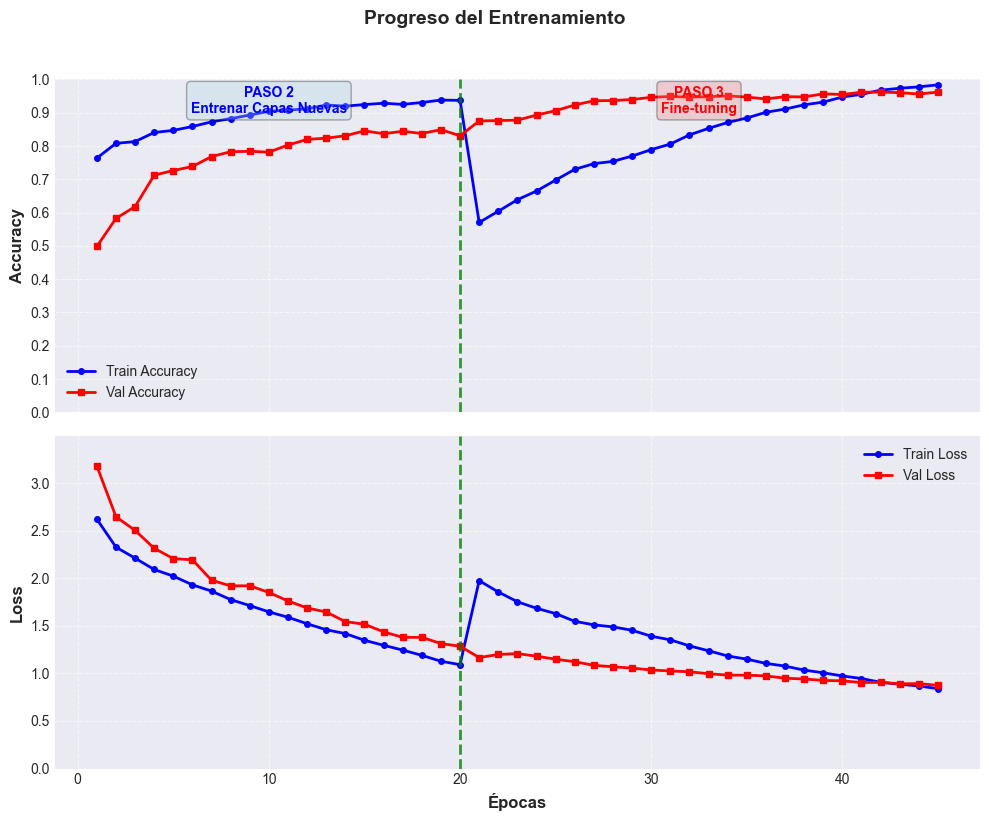

In [66]:
#grafica y resultados 

epochs_totales  = len(hist.history['loss']) + len(hist_fine_tuning.history['loss'])
split_point = len(hist.history['loss']) 


train_acc = hist.history["accuracy"] + hist_fine_tuning.history["accuracy"]
val_acc = hist.history['val_accuracy'] + hist_fine_tuning.history['val_accuracy']
train_loss = hist.history['loss'] + hist_fine_tuning.history['loss']
val_loss = hist.history['val_loss'] + hist_fine_tuning.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.style.use('seaborn-v0_8-darkgrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# accuracy
ax1.plot(epochs, train_acc, 'b-', marker='o', markersize=4, linewidth=2, label='Train Accuracy')
ax1.plot(epochs, val_acc, 'r-', marker='s', markersize=4, linewidth=2, label='Val Accuracy')
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_ylim([0.0, 1.0])  # Ajusta según tus datos
ax1.set_yticks(np.arange(0.0, 1.1, 0.1))
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, linestyle='--', alpha=0.6)

# loss
ax2.plot(epochs, train_loss, 'b-', marker='o', markersize=4, linewidth=2, label='Train Loss')
ax2.plot(epochs, val_loss, 'r-', marker='s', markersize=4, linewidth=2, label='Val Loss')
ax2.set_xlabel('Épocas', fontsize=12, fontweight='bold')
ax2.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax2.set_ylim([0.0, max(train_loss + val_loss) * 1.1])  # Ajuste automático
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, linestyle='--', alpha=0.6)


ax1.axvline(x=split_point, color='green', linestyle='--', linewidth=2, alpha=0.8)
ax2.axvline(x=split_point, color='green', linestyle='--', linewidth=2, alpha=0.8)

ax1.text(split_point/2, ax1.get_ylim()[1]*0.9, 'PASO 2\nEntrenar Capas Nuevas', 
         ha='center', fontsize=10, color='blue', fontweight='bold',
         bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.3))

ax1.text(split_point + (len(hist_fine_tuning.history['loss'])/2), 
         ax1.get_ylim()[1]*0.9, 'PASO 3\nFine-tuning', 
         ha='center', fontsize=10, color='red', fontweight='bold',
         bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.3))


plt.suptitle('Progreso del Entrenamiento', 
             fontsize=14, fontweight='bold', y=1.02)


plt.tight_layout()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicciones: [0 0 1 2 1 3 1 0 0 2 0 2 1 0 3 0]
Etiquetas re: [3 0 1 2 1 3 0 0 0 2 3 2 1 0 3 0]


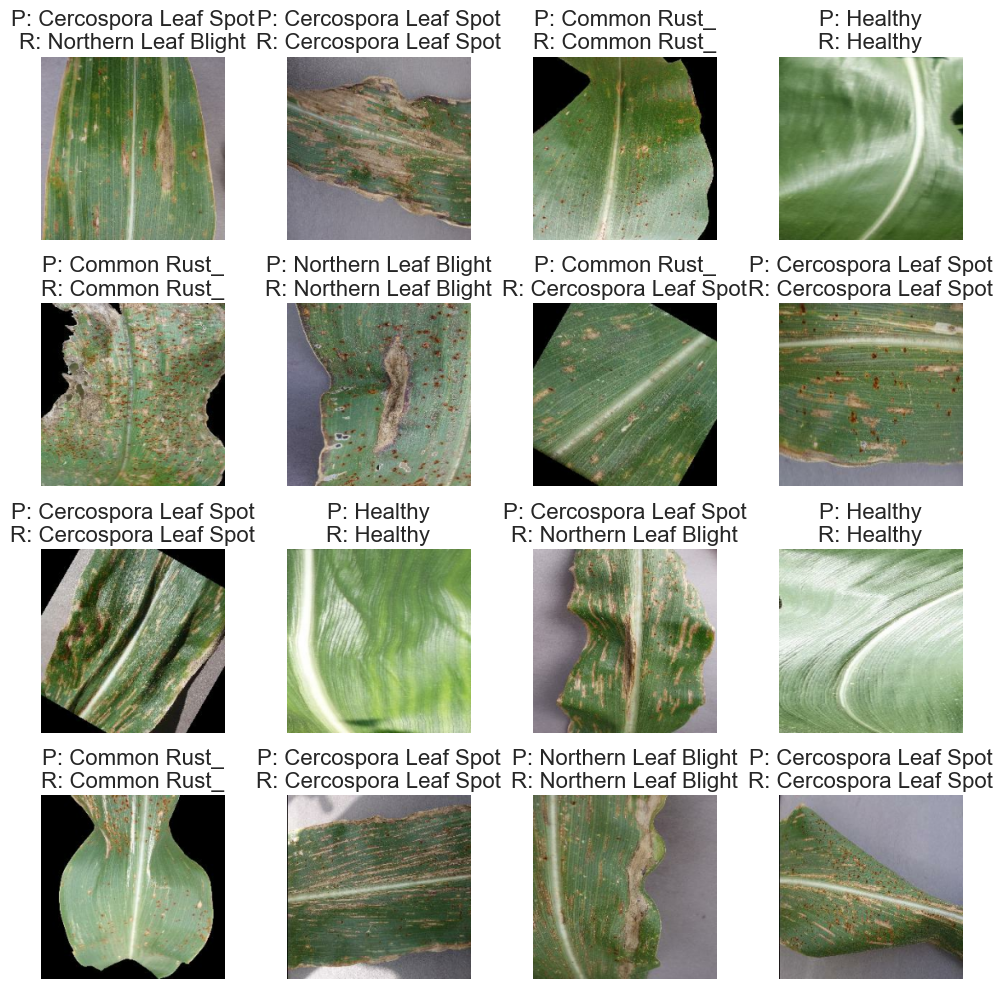

In [67]:
class_names = list(clases.keys())

imagenes = []
etiquetas = []

for img, lab in ds_test.unbatch():
    imagenes.append(img.numpy())   # Convertimos a numpy aquí
    etiquetas.append(lab.numpy())

imagenes = np.array(imagenes)
etiquetas = np.array(etiquetas)


indices = random.sample(range(len(imagenes)), 16)

imagenes_random = imagenes[indices]
etiquetas_random = etiquetas[indices]

predicciones = modelo.predict(imagenes_random)
predicciones_l = tf.argmax(predicciones, axis=1).numpy()

print("Predicciones:", predicciones_l)
print("Etiquetas re:", etiquetas_random)


plt.figure(figsize=(10, 10))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)   
    plt.imshow(imagenes_random[i].astype("uint8"))
    titulo = f"P: {class_names[predicciones_l[i]]}\nR: {class_names[etiquetas_random[i]]}"
    plt.title(titulo, fontsize=16)
    plt.axis("off")

plt.tight_layout()
plt.show()




6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step   


<Figure size 800x600 with 0 Axes>

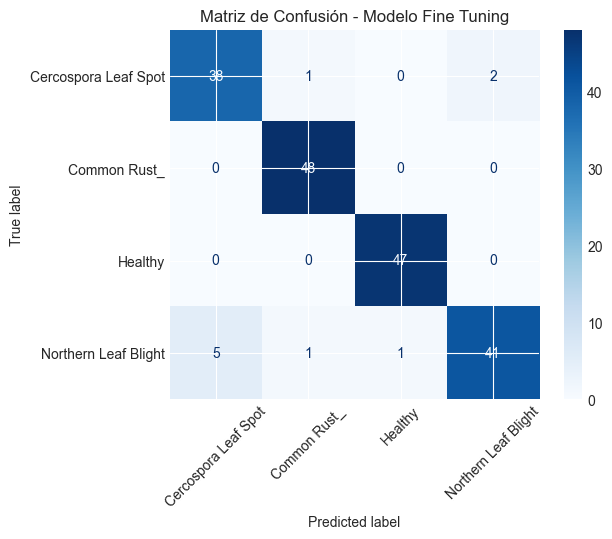

In [68]:
#crear matriz de confusionn 

y_pred_p = model_fine_tuned.predict(ds_test)
y_pred = np.argmax(y_pred_p, axis=1)

y_true = []
for _, etiquetas in ds_test.unbatch():
    y_true.append(etiquetas.numpy())

y_true = np.array(y_true)

matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=clases_names)
disp.plot(include_values=True, cmap="Blues", xticks_rotation=45)
plt.title("Matriz de Confusión - Modelo Fine Tuning")
plt.show()